# Blockchain analysis

In case you know nothing about the Bitcoin and Blockchain, you can start by watching the following video.

In [52]:
import IPython.display
IPython.display.HTML('<iframe width="750" height="430" src="https://www.youtube.com/embed/Lx9zgZCMqXE?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Basic setup

Here we will import the `pyspark` module and set up a `SparkSession`. By default, we'll use a `SparkSession` running locally, with one Spark executor; we're dealing with small data, so it doesn't make sense to run against a cluster, but the `local[1]` can be changed with the ip of the Spark cluster.


In [53]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

spark = SparkSession.builder \
                    .master("local[4]") \
                    .config("spark.driver.memory", "4g") \
                    .getOrCreate()

sc = spark.sparkContext

## Loading the data

To obtain the graph representing the transaction in the Bitcoin network, we need to load set of nodes representing the wallets (fingerprints of the public keys) and the set of edges representing each transaction. For this example we will use two parquet files that were generated from the blockchain data by this [convertor](https://github.com/Jiri-Kremser/bitcoin-insights/tree/master/parquet-converter).

In [54]:
raw_nodes = spark.read.load("/tmp/nodes1.parquet") \
                      .withColumnRenamed("_1", "id") \
                      .withColumnRenamed("_2", "Address")
raw_nodes.show(5)

+---+--------------------+
| id|             Address|
+---+--------------------+
|  0|                null|
|  1|bitcoinaddress_09...|
|  2|bitcoinaddress_CD...|
|  3|bitcoinaddress_67...|
|  4|bitcoinaddress_BD...|
+---+--------------------+
only showing top 5 rows



As you can see, each record in the Address column contains a string `bitcoinaddress_<hash>`, where the hash is the actual address. Let's remove the redundant prefix.

In [55]:
nodes = raw_nodes.withColumn("Address", regexp_replace("Address", "bitcoinaddress_", "")).cache()
nodes.show(5)

+---+--------------------+
| id|             Address|
+---+--------------------+
|  0|                null|
|  1|09A7415A5CB9E8403...|
|  2|CDB650673CB9EE3F4...|
|  3|67C49F2B17148E1E1...|
|  4|BDED87E58ED5E4226...|
+---+--------------------+
only showing top 5 rows



We can also verify, that these addresses are real on https://blockchain.info/address/. 

Example:
 1. get a random BTC address
 1. create the link from the address

In [99]:
random_address = nodes.rdd.takeSample(False, 1)[0][1]
IPython.display.Markdown('link of the random wallet: https://blockchain.info/address/' + random_address)

link of the random wallet: https://blockchain.info/address/4C3A62399007A726014126AEECCE2B9B0BA05314

In [93]:
raw_edges = spark.read.load("/tmp/edges1.parquet") \
                      .withColumnRenamed("srcId", "src") \
                      .withColumnRenamed("dstId", "dst") \
                      .drop("attr") \
                      .cache()
raw_edges.show(5)
raw_edges.count()

+-------+-------+
|    src|    dst|
+-------+-------+
|1125302|1402434|
| 360021| 675794|
|1147019| 675794|
|  98136| 838518|
| 224468| 838518|
+-------+-------+
only showing top 5 rows



15489923

## Data cleansing

Remove the self-loops.

In [94]:
edges = raw_edges.filter("src != dst")
edges.show(5)
edges.count()

+-------+-------+
|    src|    dst|
+-------+-------+
|1125302|1402434|
| 360021| 675794|
|1147019| 675794|
|  98136| 838518|
| 224468| 838518|
+-------+-------+
only showing top 5 rows



12716477

## Constructing the graph representation

Spark contains API for graph processing. It's called [graphx](https://spark.apache.org/graphx/) and it also comes with multiple built-in algorithms like page-rank. It uses the [Pregel API](https://spark.apache.org/docs/latest/graphx-programming-guide.html#pregel-api).

In [95]:
from graphframes import *

g = GraphFrame(nodes, edges).cache()

#### Get the top 10 wallets with respect to the transaction count

First, by sorting the nodes by `inDegree` which corresponds to the number of transactions received.

In [96]:
vertexDegrees = g.inDegrees \
                 .join(g.outDegrees, "id") \
                 .drop("id")
vertexDegrees.show(5, False)

+--------+---------+
|inDegree|outDegree|
+--------+---------+
|2       |1        |
|2       |1        |
|1       |1        |
|4       |3        |
|14      |2        |
+--------+---------+
only showing top 5 rows



In [97]:
vertexDegrees.describe() \
             .show()

+-------+------------------+------------------+
|summary|          inDegree|         outDegree|
+-------+------------------+------------------+
|  count|            785821|            785821|
|   mean|15.276728415249783|11.112150222506143|
| stddev| 3918.020271118844|1376.2178691820588|
|    min|                 1|                 1|
|    max|           3441528|           1217842|
+-------+------------------+------------------+



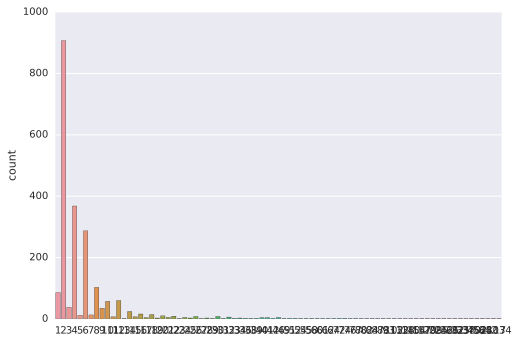

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
from scipy import stats
sns.set(color_codes=True)

_ = sns.countplot([int(i.inDegree) for i in vertexDegrees.sample(False, 0.003).select("inDegree").collect()])

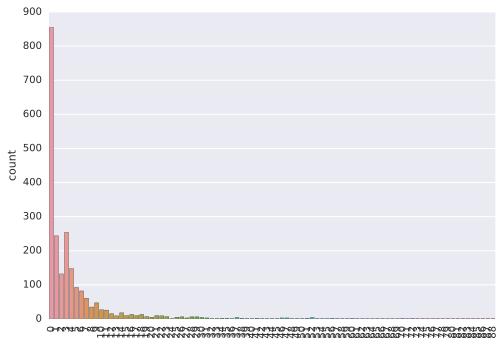

In [51]:
_ = sns.countplot([int(i.outDegree) for i in vertexDegrees.sample(False, 0.003).select("outDegree").collect()])

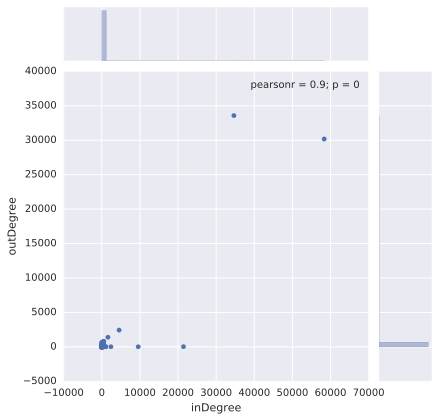

In [65]:
sns.jointplot(x="inDegree", y="outDegree", data=vertexDegrees.sample(False, 0.01, 42).toPandas());

In [62]:
vertexDegrees.select(corr("inDegree", "outDegree")) \
             .show()

+-------------------------+
|corr(inDegree, outDegree)|
+-------------------------+
|       0.9382223902728456|
+-------------------------+



In [120]:
probs = [i*1.0/20 for i in range(0,20)]
quantiles = vertexDegrees.approxQuantile("inDegree", probs, 0.03)
quantiles

[1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 4.0,
 6.0,
 8.0,
 8.0,
 16.0]

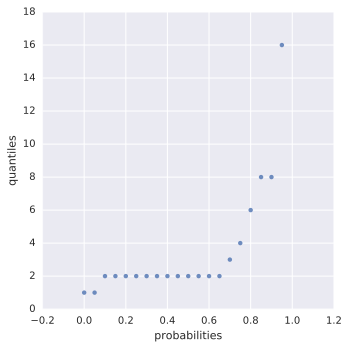

In [121]:
import pandas as pd
p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})

sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

In [116]:
def create_graph(id):
    nodes = spark.read.load("/tmp/nodes" + id +".parquet").withColumnRenamed("_1", "id")
    raw_edges = spark.read.load("/tmp/edges" + id +".parquet") \
                          .withColumnRenamed("srcId", "src").withColumnRenamed("dstId", "dst") \
                          .drop("attr")

    edges = raw_edges.filter("src != dst")
    self_loops = raw_edges.count() - edges.count()
    print("Graph " + id + " - self-loops count: " + str(self_loops))
    g = GraphFrame(nodes, edges)
    degrees = g.inDegrees.join(g.outDegrees, "id").drop("id")
    return [g, degrees]

g1, degrees1 = create_graph("1")
g2, degrees2 = create_graph("2")

Graph 1 - self-loops count: 741402
Graph 2 - self-loops count: 1778409


In [114]:
degrees1.describe().show()
degrees2.describe().show()

+-------+------------------+------------------+
|summary|          inDegree|         outDegree|
+-------+------------------+------------------+
|  count|            736724|            736724|
|   mean|14.406647536933777|12.855146567778435|
| stddev| 539.0410465800433| 539.1684722174649|
|    min|                 1|                 1|
|    max|            183180|            182107|
+-------+------------------+------------------+

+-------+------------------+-----------------+
|summary|          inDegree|        outDegree|
+-------+------------------+-----------------+
|  count|            964723|           964723|
|   mean| 66.12532509331695|57.77604452262463|
| stddev|2221.9312187664564|1864.905786145403|
|    min|                 1|                1|
|    max|           1219638|          1045704|
+-------+------------------+-----------------+



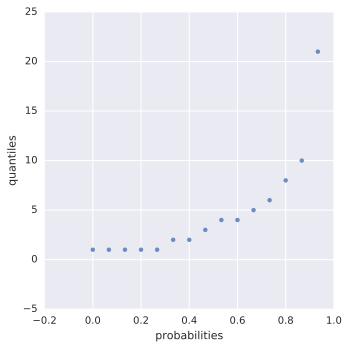

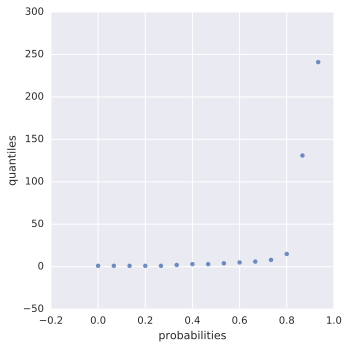

In [127]:
def plot_quantiles(degrees):
    probs = [i*1.0/15 for i in range(0,15)]
    quantiles = degrees.approxQuantile("outDegree", probs, 0.03)
    p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})
    sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

plot_quantiles(degrees1)
plot_quantiles(degrees2)

#### Find circles of length 2

In [133]:
# motifs = g.find("(a)-[]->(b); (b)-[]->(a)")
# motifs.count()
# # motifs.show(5)

motifs = g.find("(a)-[]->(b); (b)-[]->(c)")
motifs.count()
# motifs.show(5)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38807)
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
  File "/opt/conda/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:38807)

## Visualization of a sub-graph

Our data contain a lot of transactions (2 087 249 transactions among 546 651 wallets) so let's show only a small fraction of the transaction graph. We will show all the outgoing transaction of particular bitcoin address.

In [129]:
from pyspark.sql.functions import col
import random

# feel free to use any address that is present in the dataset
address = senders.take(1000)[999].Wallet

sub_graph = g.find("(src)-[e]->(dst)") \
             .filter(col('src.Wallet') == address)
    
def node_to_dict(r):
    return {
        'id': r[0],
        'label': r[1],
        'x': random.uniform(0,1),
        'y': random.uniform(0,1),
        'size': random.uniform(0.2,1)
    }

sub_nodes = sub_graph.select("dst.id", "dst.Wallet").distinct()
sub_edges = sub_graph.select("e.src", "e.dst")

target_nodes_dict = map(node_to_dict, sub_nodes.collect())

def edge_to_dict(i, r):
    return {
        'id': i,
        'source': r[0],
        'target': r[1]
    }

sub_edges_dict = [edge_to_dict(i, r) for i, r in enumerate(sub_edges.collect())]

target_nodes_dict.append({
    'id': sub_edges.first()['src'],
    'label': address,
    'color': '#999',
    'x': -1,
    'y': 0.5,
    'size': 2
})

NameError: name 'senders' is not defined

Now we are ready to show the data using the [sigmajs](sigmajs.org) library.

In [65]:
%%javascript
require.config({
    paths: {
        sigmajs: 'https://cdnjs.cloudflare.com/ajax/libs/sigma.js/1.2.0/sigma.min'
    }
});

require(['sigmajs']);

<IPython.core.display.Javascript object>

In [87]:
from IPython.core.display import display, HTML
from string import Template
import json

js_text_template = Template(open('js/sigma-graph.js','r').read())

graph_data = { 'nodes': target_nodes_dict, 'edges': sub_edges_dict }

js_text = js_text_template.substitute({'graph_data': json.dumps(graph_data),
                                       'container': 'graph-div'})

html_template = Template('''
<div id="graph-div" style="height:400px"></div>
<script> $js_text </script>
''')

HTML(html_template.substitute({'js_text': js_text}))